In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils

import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer


In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/outData.csv')

## Filter for only HipHop and Country Songs

In [3]:
song_data = song_data[(song_data['Genre'] == "Country") | (song_data['Genre'] == "Hip-Hop")]
song_data

,Artist,Song,Genre,Language,Lyrics
231722,aaron smith,superhero,Hip-Hop,en,"Yeah Sometimes, i just wanna fly away. They sa..."
231724,geto boys,the secret,Hip-Hop,en,You know what? I'm destined to be the last man...
231725,brad paisley,be the lake,Country,en,There ain't nothing that I would rather see Th...
231726,atmosphere,tracksmart,Hip-Hop,en,(Mr. Gene Poole) Lovin' this sound comin out t...
231728,fabolous,want you back,Hip-Hop,en,"You see, what I can't understand Is how somebo..."
...,...,...,...,...,...
250171,cowboy junkies,my only guarantee,Country,en,Keep it coming I've got your back Do not fear ...
250175,diplomats,dipset symphony,Hip-Hop,en,I don't give a fuck who's first or who's last ...
250183,george strait,gone as a girl can get,Country,en,"Well I haven't seen her lately, and she never ..."
250186,chris ledoux,national finals rodeo,Country,en,A rodeo's just a rodeo after riding several ye...


In [4]:
num_genres = song_data.Genre.nunique()
num_topics = 5

In [5]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,Longneck bottle Let go of my hand Hey jukebox ...
1,Country,I should have known that you were trouble when...
2,Country,"He was sittin' at the bar, sippin' on a regula..."
3,Country,"Cledus T. Judd/Vern Dant, La-Po Music (BMI)/Mu..."
4,Country,you left a message on my phone you knew I woul...
5,Country,Others have touched me Soft in the night Other...
6,Country,You got the obstacles out of the way All of th...
7,Country,You let him lock you away in his prison of sad...
8,Country,It's funny how love goes 'Cause I know this co...
9,Country,I don't know what to think of it Sometimes I h...


## Remove punctuation/lower casing

In [6]:
song_data_processed = song_data.copy()
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: re.sub('[,\.!?]', '', x))
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].map(lambda x: x.lower())

## Remove stopwords and Tokenize

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [9]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [10]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [11]:
lda.print_topics(num_words=10)

[(0,
  '0.009*"away" + 0.008*"ever" + 0.008*"world" + 0.008*"us" + 0.008*"would" + 0.007*"eyes" + 0.007*"long" + 0.006*"always" + 0.006*"gone" + 0.006*"another"'),
 (1,
  '0.018*"niggas" + 0.011*"yo" + 0.011*"bitch" + 0.010*"money" + 0.008*"real" + 0.006*"hit" + 0.006*"ass" + 0.006*"bitches" + 0.005*"gon" + 0.005*"new"'),
 (2,
  '0.026*"da" + 0.019*"girl" + 0.014*"wit" + 0.014*"ass" + 0.013*"blow" + 0.012*"shake" + 0.012*"yo" + 0.011*"im" + 0.011*"body" + 0.010*"bitch"'),
 (3,
  '0.018*"girl" + 0.015*"la" + 0.012*"gotta" + 0.010*"tonight" + 0.008*"something" + 0.008*"really" + 0.008*"things" + 0.008*"gone" + 0.007*"bad" + 0.007*"going"'),
 (4,
  '0.019*"old" + 0.014*"dem" + 0.013*"mi" + 0.012*"town" + 0.010*"di" + 0.009*"ah" + 0.008*"mind" + 0.008*"away" + 0.007*"lady" + 0.007*"everybody"')]

### Auswertung Topics

In [12]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
results

,Genre,Lyrics,0,1,2,3,4,Dominant_Topic
0,Country,longneck bottle let go of my hand hey jukebox ...,0.000000,0.000000,0.000000,0.792768,0.191880,3
1,Country,i should have known that you were trouble when...,0.851307,0.000000,0.000000,0.000000,0.137729,0
2,Country,he was sittin' at the bar sippin' on a regular...,0.000000,0.159839,0.110350,0.542713,0.184118,3
3,Country,cledus t judd/vern dant la-po music (bmi)/musi...,0.261098,0.501977,0.000000,0.209595,0.025394,1
4,Country,you left a message on my phone you knew i woul...,0.522914,0.000000,0.000000,0.466662,0.000000,0
...,...,...,...,...,...,...,...,...
1995,Hip-Hop,lord have mercy i'm so controversy bet you've ...,0.293045,0.612453,0.000000,0.092644,0.000000,1
1996,Hip-Hop,[chorus:] why not me is it that i'm too ghetto...,0.071148,0.316554,0.000000,0.605575,0.000000,3
1997,Hip-Hop,[lil' mo] damn i got honey right here i like t...,0.484279,0.320384,0.000000,0.185498,0.000000,0
1998,Hip-Hop,mustard on the beat ho we in the club shit's p...,0.000000,0.616444,0.264264,0.116877,0.000000,1


### Explore Results

#### Crosstab

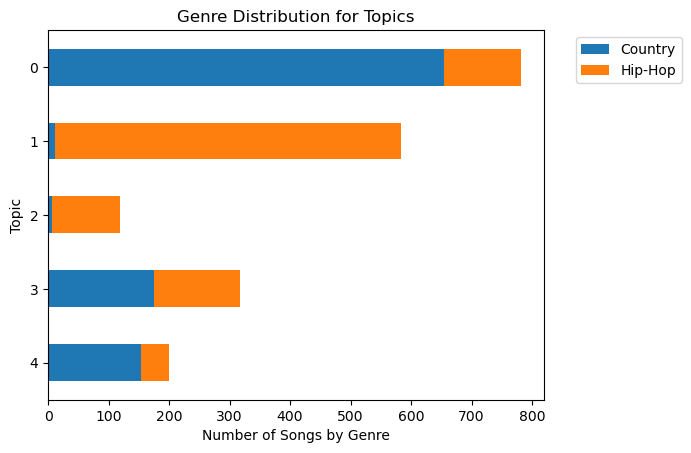

In [13]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'], results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Genre Distribution for Topics')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

In [14]:
results

,Genre,Lyrics,0,1,2,3,4,Dominant_Topic
0,Country,longneck bottle let go of my hand hey jukebox ...,0.000000,0.000000,0.000000,0.792768,0.191880,3
1,Country,i should have known that you were trouble when...,0.851307,0.000000,0.000000,0.000000,0.137729,0
2,Country,he was sittin' at the bar sippin' on a regular...,0.000000,0.159839,0.110350,0.542713,0.184118,3
3,Country,cledus t judd/vern dant la-po music (bmi)/musi...,0.261098,0.501977,0.000000,0.209595,0.025394,1
4,Country,you left a message on my phone you knew i woul...,0.522914,0.000000,0.000000,0.466662,0.000000,0
...,...,...,...,...,...,...,...,...
1995,Hip-Hop,lord have mercy i'm so controversy bet you've ...,0.293045,0.612453,0.000000,0.092644,0.000000,1
1996,Hip-Hop,[chorus:] why not me is it that i'm too ghetto...,0.071148,0.316554,0.000000,0.605575,0.000000,3
1997,Hip-Hop,[lil' mo] damn i got honey right here i like t...,0.484279,0.320384,0.000000,0.185498,0.000000,0
1998,Hip-Hop,mustard on the beat ho we in the club shit's p...,0.000000,0.616444,0.264264,0.116877,0.000000,1


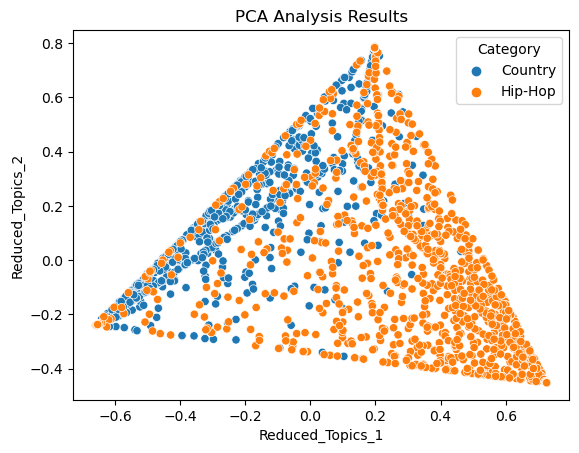

In [15]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [16]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,Dominant_Topic,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,longneck bottle let go of my hand hey jukebox ...,0.000000,0.000000,0.000000,0.792768,0.191880,3,0.184274,0.707840,0
1,Country,i should have known that you were trouble when...,0.851307,0.000000,0.000000,0.000000,0.137729,0,-0.545662,-0.148502,1
2,Country,he was sittin' at the bar sippin' on a regular...,0.000000,0.159839,0.110350,0.542713,0.184118,3,0.273089,0.455031,0
3,Country,cledus t judd/vern dant la-po music (bmi)/musi...,0.261098,0.501977,0.000000,0.209595,0.025394,1,0.236853,-0.114797,0
4,Country,you left a message on my phone you knew i woul...,0.522914,0.000000,0.000000,0.466662,0.000000,0,-0.253315,0.243386,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,Hip-Hop,lord have mercy i'm so controversy bet you've ...,0.293045,0.612453,0.000000,0.092644,0.000000,1,0.269448,-0.275605,0
1996,Hip-Hop,[chorus:] why not me is it that i'm too ghetto...,0.071148,0.316554,0.000000,0.605575,0.000000,3,0.303859,0.318732,0
1997,Hip-Hop,[lil' mo] damn i got honey right here i like t...,0.484279,0.320384,0.000000,0.185498,0.000000,0,-0.050507,-0.114970,1
1998,Hip-Hop,mustard on the beat ho we in the club shit's p...,0.000000,0.616444,0.264264,0.116877,0.000000,1,0.530850,-0.133504,0


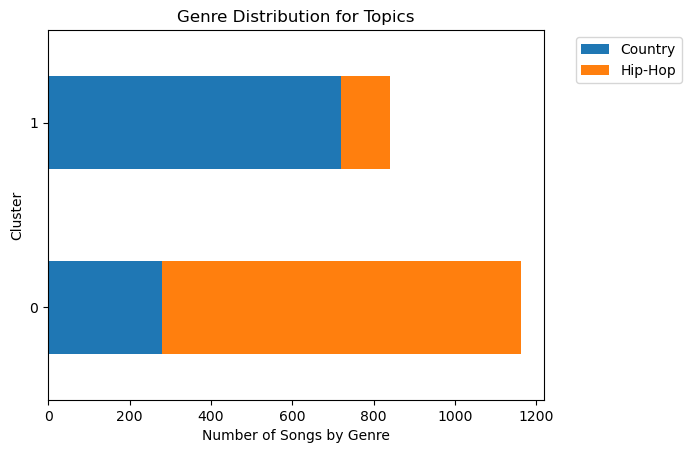

In [17]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

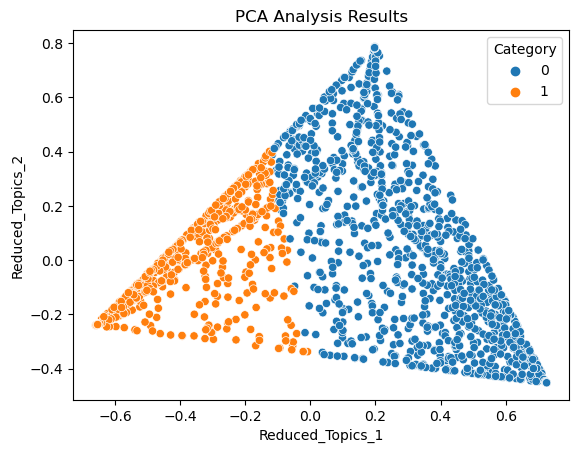

In [18]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [19]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [20]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.8916666666666667

In [21]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.8866666666666667

In [22]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.86

### Get Classification Matrix (of knn)

In [23]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       302
           1       0.91      0.85      0.88       298

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



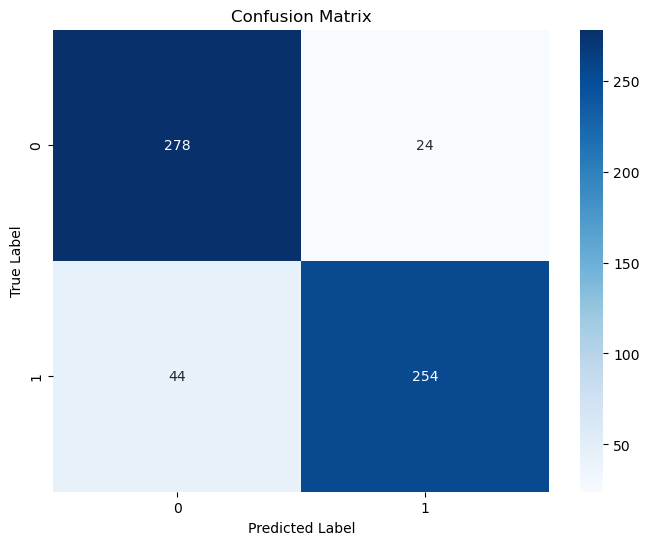

In [24]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = svc.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Hip-Hop,1


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus den Genres HipHop und Country
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 
- Variation der Anzahl der topics um zu vergleichen was die besten ergebnisse liefert

### Ergebnis
- Starker unterschied zwischen den Themen bei HipHop und Country Songs
- Country Songs fallen kaum in die Hip-Hop Kategorie, während dies anders herum schon teilweise der Fall ist (HipHop ist also doch etwas offener im Topic)
- Starkes HipHop Topic mit vielen slang begriffen, während country category etwas freier gehalten ist (zumindest bei 2 topics)
- Ergebnisse sehr viel eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics extrem gut möglich, accuracy bis zu 87%
- Die Ergebnisse sind nahezu identisch bei Erhöhung der Anzahl der Topics auf 10, einzig die PCA zeigt dabei etwas visuellere Ergebnisse und auch das Clustering scheint in Ordnung zu funktionieren
- Bei 20 Topics nimmt die Qualität der Ergebnisse ab
- ca. 5 topics scheint der sweet spot zu sein, damit steigt die accuracy auf bis zu 89%
- Clustering der Ergebnisse Funktioniert nicht, dafür sind die Ergebnisse nicht eindeutig genug abgetrennt


### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.
- Es ist gut möglich anhand der Lyrics zu unterscheiden ob ein Song Hip-Hop oder Country zugeordnet werden kann